## 神经网络解决多分类问题
+ 案例：手写数字识别
+ 数据集：ex4data1.mat
+ 初始参数：ex4weights.mat
+ <mark>在 ex3 Homework 里面，我们是已经给定了最优的一个权重参数，作为 theta 代入到前向传播中，然后算得最终的预测值即可，而在 ex4 Homework 中我们需要搭建完整的一个神经网络，并且自己去进行训练，找到优化的权重参数</mark>
+ **前向传播计算出了输出值（也即预测值），就可以根据输出值与目标值的差别来计算损失loss。反向传播就是根据损失函数loss来反方向地计算每一层的偏导数，从最后一层逐层向前去改变每一层的权重，也就是更新参数，核心就是损失函数对每一网络层的每一个参数求偏导的链式求导法则。**


In [4]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [7]:
data = sio.loadmat('ex4data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [15]:
# 数据预处理
raw_X = data['X']
raw_y = data['y']
raw_X.shape, raw_y.shape

((5000, 400), (5000, 1))

In [16]:
X = np.insert(raw_X, 0, values=1, axis=1)
X, X.shape

(array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]),
 (5000, 401))

In [13]:
# 之前我们对 y 的处理是使用 flatten() 函数将 y 这个二维数组降低为一维数组，为了算最后的准确率比较方便
# 但是我们这里将采用另外的方式

## 1. 对 y 进行独热编码处理：one-hot 编码

![image.png](<https://i.typlog.com/tanxy/8336448553_535999.png>)

**y 里面的每一个数字将会由 10 个数字进行代替，且这 10 个数字的取值只能是 0 和 1**

In [28]:
def one_hot_encoder(raw_y):
    
    result = []
    
    for i in raw_y: 
        # i 的取值为 1- 10 (这里理解会好一点，raw_y 里面为 5000 个 1-10 的数字)
        # for 循环里面的 i 指的是具体某 y 的值，而不是下标
        # print(i)
        y_temp = np.zeros(10)
        y_temp[i-1] = 1   
        # 这一步非常妙！！每一个 for 循环先初始化一个长度为 10 ，数值全为 0 的数组，然后对 raw_y 里面的每一个数字进行循环
        # 假设这次扫描到的 raw_y 数值为 10，则我们令这次初始化数组的下标为 10-1=9 的位置为 1，那么就是[0,0,0,0,0,0,0,0,0,1] 刚好就是 10 的表示方法
        # 假设这次扫描到的 raw_y 数值为 5，则我们令这次初始化数组的下标为 5-1=4 的位置为 1，那么就是[0,0,0,0,1,0,0,0,0,1] 刚好就是 5 的表示方法
        #如此类推
        
        result.append(y_temp) # 每次循环将已经转换好的数组追加至 result 列表中
        
    return np.array(result) # 因为 result 本来是一个列表，我们要转换成数组形式

In [31]:
y = one_hot_encoder(raw_y)
y, y.shape 
# 可以看出 raw_y 已经成功转换成独热编码的 y，并且从 y 的 shape 可以看出，原本 (5000,1) -> (5000,10) 原本每个 1~10 的数字已经成功转换成 只有 0和1 组成的长度为 10 的向量

(array([[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.]]),
 (5000, 10))

In [38]:
# 先读取权重参数
theta = sio.loadmat('ex4weights.mat')
theta1, theta2 = theta['Theta1'], theta['Theta2']
theta1.shape, theta2.shape

((25, 401), (10, 26))

## 2.序列化权重参数
> 为什么要序列化权重参数，因为我们后面使用 scipy optimize 子模块优化的时候，里面传入的 theta 是一维数组的形式，而我们现在的 theta1,theta2 是二维数组的形式，所以传进来的时候维度是不匹配的，包括后面的梯度向量也要处理成这样的形式

In [40]:
# 所以我们干脆定义一个序列化的函数，方便处理 theta 和 梯度向量
def serialize(a, b):
    return np.append(a.flatten(), b.flatten())

In [41]:
theta_serialize = serialize(theta1, theta2)

In [44]:
theta_serialize # 序列化后的 theta

array([-2.25623899e-02, -1.05624163e-08,  2.19414684e-09, ...,
       -2.47795788e-01,  1.28009118e+00, -1.32752042e+00])

In [46]:
theta_serialize.shape # 可验证，已经处理为一维数组

(10285,)

## 3.解序列化权重参数

In [49]:
def deserialize(theta_serialize):
    theta1 = theta_serialize[:25*401].reshape(25,401)
    theta2 = theta_serialize[25*401:].reshape(10,26)
    return theta1, theta2

In [51]:
theta1, theta2 = deserialize(theta_serialize)

In [53]:
theta1.shape, theta2.shape

((25, 401), (10, 26))

## 4.前向传播

In [55]:
# 定义激活函数 sigmoid 函数
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [58]:
# 前向传播函数
def feed_forward(theta_serialize,X):
    theta1, theta2 = deserialize(theta_serialize) # 解序列化
    a1 = X
    z2 = a1 @ theta1.T
    a2 = sigmoid(z2)
    a2 = np.insert(a2, 0, values=1, axis=1) # 记得添加偏置项常数列 1（因为这时的 shape 不一样）
    z3 = a2 @ theta2.T
    h = sigmoid(z3)
    return a1,z2,a2,z3,h

## 5.损失函数

### 5-1 不带正则化的损失函数
![image.png](<https://i.typlog.com/tanxy/8336429836_691473.png>)

In [62]:
def cost(theta_serialize,X,y):
    a1,z2,a2,z3,h = feed_forward(theta_serialize,X)
    J = -np.sum(y*np.log(h)+(1-y)*np.log(1-h)) / len(X)
    return J

In [63]:
# 查看不带正则化的损失函数的初始值
cost(theta_serialize,X,y)

0.2876291651613189

### 5-2 带正则化的损失函数
![image.png](<https://i.typlog.com/tanxy/8336429751_287485.png>)

In [70]:
def reg_cost(theta_serialize,X,y,lamda):
    sum1 = np.sum(np.power(theta1[:,1:],2))
    sum2 = np.sum(np.power(theta2[:,1:],2))
    reg = (sum1 + sum2) * lamda / (2 *len(X))
    return reg + cost(theta_serialize,X,y) # 加上不带正则化的

In [71]:
# 查看给定初始值条件下带正则化的损失函数的初始值
lamda = 1
reg_cost(theta_serialize,X,y,lamda)

0.38376985909092365

## 6.反向传播

### 6-1 无正则化的梯度

In [107]:
# sigmoid 函数的导数
def sigmoid_gradient(z):
    return sigmoid(z) * (1-sigmoid(z))

In [108]:
# 不带正则化的梯度
def gradient(theta_serialize,X,y):
    theta1, theta2 = deserialize(theta_serialize)
    a1,z2,a2,z3,h = feed_forward(theta_serialize,X) # 进行前向传播
    d3 = h - y
    d2 = d3 @ theta2[:,1:] * sigmoid_gradient(z2)
    D2 = (d3.T @ a2) / len(X) # 也是维度的问题，要转置一下
    D1 = (d2.T @ a1) / len(X)
    return serialize(D1, D2)

### 6-3 带正则化的梯度

In [110]:
def reg_gradient(theta_serialize,X,y,lamda):
    D = gradient(theta_serialize,X,y)
    D1, D2 = deserialize(D)
    
    theta1, theta2 = deserialize(theta_serialize)
    D1[:,1:] = D1[:,1:] + theta1[:,1:] * lamda / len(X)
    D2[:,1:] = D2[:,1:] + theta2[:,1:] * lamda / len(X)
    
    return serialize(D1, D2)

## 7.神经网络的优化

In [111]:
from scipy.optimize import minimize

def nn_training(X,y):
    
    init_data = np.random.uniform(-0.5,0.5,10285)
    res = minimize(fun = reg_cost,
                  x0 = init_data,
                  args = (X,y,lamda),
                  method = 'TNC',
                  jac = reg_gradient,
                  options = {'maxiter':300} # 最大迭代次数 300 次
                  )
    return res

In [112]:
lamda = 10
res = nn_training(X,y)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_220\4005477587.py:6: DeprecationWarning: 'maxiter' has been deprecated in favor of 'maxfun' and will be removed in SciPy 1.11.0.
  res = minimize(fun = reg_cost,


In [113]:
raw_y = data['y'].reshape(5000,)

In [115]:
_,_,_,_,h = feed_forward(res.x,X)
y_pred = np.argmax(h,axis=1) + 1
acc = np.mean(y_pred == raw_y)

acc

0.9402

## 8.可视化隐藏层

In [118]:
def plot_hidden_layer(theta):
    theta1,_ = deserialize(theta)
    hidden_layer = theta1[:,1:] # 25,400
    
    
    fig,ax = plt.subplots(ncols=5,nrows=5,figsize=(8,8),sharex=True,sharey=True)
    
    for r in range(5):
        for c in range(5):
            
            ax[r,c].imshow(hidden_layer[5 * r + c].reshape(20,20).T,cmap='gray_r')
            
    plt.xticks([])
    plt.yticks([])
    
    plt.show()

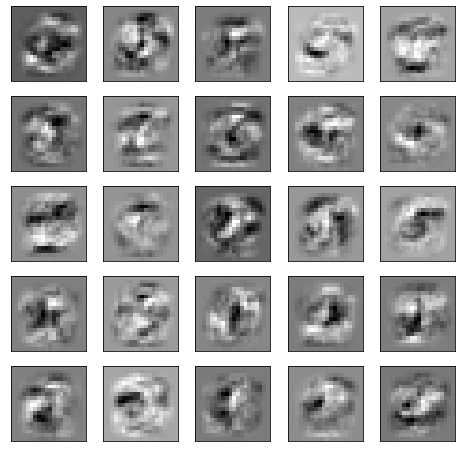

In [120]:
# 可视化
plot_hidden_layer(res.x)
# 表示隐藏层所学到的一些特征